In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# For dimensionality reduction (optional for visualization)
from sklearn.decomposition import PCA

In [2]:
df_customers = pd.read_csv("/kaggle/input/cpt-data/Customers.csv")
df_products = pd.read_csv("/kaggle/input/cpt-data/Products.csv")
df_transactions = pd.read_csv("/kaggle/input/cpt-data/Transactions.csv")

In [3]:
df_merged = df_transactions.merge(df_customers, on='CustomerID', how='left')
df_merged = df_merged.merge(df_products, on='ProductID', how='left')

In [4]:
customer_data = df_merged.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "TransactionID": "count",
    "Quantity": "sum"  # maybe also consider total items purchased
}).rename(columns={
    "TotalValue":"total_spend",
    "TransactionID":"transaction_count",
    "Quantity":"total_quantity"
})

In [5]:
region_dummies = pd.get_dummies(df_customers.set_index("CustomerID")['Region'], prefix="region")
customer_data = customer_data.join(region_dummies, how="left")

In [6]:
df_customers['SignupDate'] = pd.to_datetime(df_customers['SignupDate'], errors='coerce')
max_date = df_customers['SignupDate'].max()
df_customers['days_since_signup'] = (max_date - df_customers['SignupDate']).dt.days
customer_data['days_since_signup'] = df_customers.set_index("CustomerID")['days_since_signup']


In [7]:
customer_data.fillna(0, inplace=True)

In [8]:
X = customer_data.values  # numeric matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
k_range = range(2, 11)
db_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    db_index = davies_bouldin_score(X_scaled, labels)
    db_scores.append(db_index)
    print(f"k={k}, Davies-Bouldin Index={db_index:.4f}")

k=2, Davies-Bouldin Index=1.7867
k=3, Davies-Bouldin Index=1.5403
k=4, Davies-Bouldin Index=1.1210
k=5, Davies-Bouldin Index=1.0265
k=6, Davies-Bouldin Index=1.0383
k=7, Davies-Bouldin Index=1.0646
k=8, Davies-Bouldin Index=0.9588
k=9, Davies-Bouldin Index=1.0149
k=10, Davies-Bouldin Index=1.0161


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


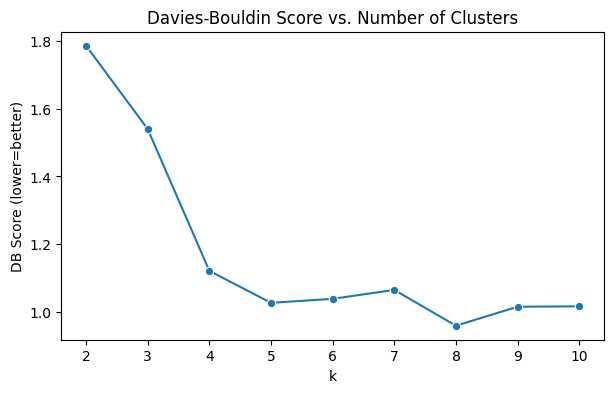

In [20]:
plt.figure(figsize=(7,4))
sns.lineplot(x=list(k_range), y=db_scores, marker='o')
plt.title("Davies-Bouldin Score vs. Number of Clusters")
plt.xlabel("k")
plt.ylabel("DB Score (lower=better)")
plt.show()

In [23]:
best_k = k_range[np.argmin(db_scores)]  # the k that yields the lowest DB index
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
labels_final = kmeans_final.fit_predict(X_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [22]:
customer_data['Cluster'] = labels_final

In [13]:
print(f"\nChosen k={best_k}")
print(customer_data.head())


Chosen k=8
            total_spend  transaction_count  total_quantity  region_Asia  \
CustomerID                                                                
C0001           3354.52                  5              12        False   
C0002           1862.74                  4              10         True   
C0003           2725.38                  4              14        False   
C0004           5354.88                  8              23        False   
C0005           2034.24                  3               7         True   

            region_Europe  region_North America  region_South America  \
CustomerID                                                              
C0001               False                 False                  True   
C0002               False                 False                 False   
C0003               False                 False                  True   
C0004               False                 False                  True   
C0005               Fals

In [14]:
pca = PCA(n_components=2, random_state=42)
coords_2d = pca.fit_transform(X_scaled)

cluster_df = pd.DataFrame({
    'PC1': coords_2d[:,0],
    'PC2': coords_2d[:,1],
    'Cluster': labels_final
})

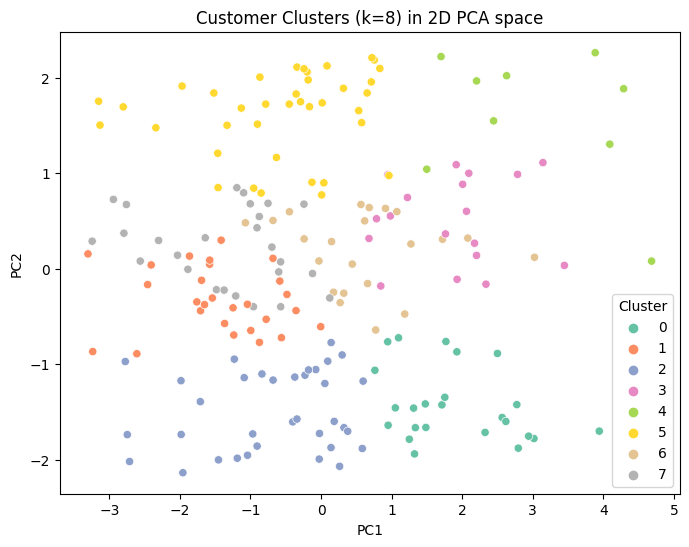

In [15]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=cluster_df, x='PC1', y='PC2', hue='Cluster', palette='Set2')
plt.title(f"Customer Clusters (k={best_k}) in 2D PCA space")
plt.show()


In [16]:
cluster_summary = customer_data.groupby('Cluster').mean()
print("\nCluster Summary (mean feature values):")
print(cluster_summary)



Cluster Summary (mean feature values):
         total_spend  transaction_count  total_quantity  region_Asia  \
Cluster                                                                
0        5404.412500           6.875000       19.208333          0.0   
1        2120.349259           3.481481        8.037037          0.0   
2        2561.333143           3.971429        9.371429          0.0   
3        5379.353889           7.500000       19.611111          1.0   
4        6606.106667           9.111111       23.666667          0.0   
5        2724.534474           4.526316       10.710526          0.0   
6        4469.605909           5.909091       15.954545          0.0   
7        2124.869231           3.192308        7.961538          1.0   

         region_Europe  region_North America  region_South America  \
Cluster                                                              
0             0.000000              0.000000                   1.0   
1             1.000000       